In [1]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle

import resource
soft, hard = resource.getrlimit(resource.RLIMIT_NOFILE)
resource.setrlimit(resource.RLIMIT_NOFILE, (hard, hard))

from os import listdir,mkdir
from PyPDF2 import PdfMerger
from os.path import isdir, isfile
from PyCircos_Utils import *

rcParams = {'font.size': 24, 'font.weight': 'normal', 'font.family': 'sans-serif',
            'axes.unicode_minus':False, 'axes.labelweight':'normal'}

plt.rcParams.update(rcParams)

osa_len = 2932766
osb_len = 3046682

COG_Description = {'D':'D- Cell cycle control, cell division,\n chromosome paritioning',
                   'M': 'M- Cell wall/membrane/envelope\n biogenesis','N' :'N- Cell motility',
                   'O': 'O- Post-translational modification, protein \nturnover, and chaperones',
                   'T': 'T- Signal transduction mechanisms',
                   'U': 'U- Intracellular trafficking, secretion, \n and vesicular transport',
                   'V': 'V- Defense mechanisms','W': 'W- Extracellular structures','Y': 'Y- Nuclear structure',
                   'Z': 'Z- Cytoskeleton','A': 'A- RNA processing and\n modification',
                   'B': 'B- Chromatin structure and\n dynamics',
                   'J': 'J- Translation, ribosomal structure \n and biogenesis','K': 'K- Transcription',
                   'L': 'L- Replication, recombination\n and repair','C': 'C- Energy production\n and conversion',
                   'E': 'E- Amino acid transport\n and metabolism','F': 'F- Nucleotide transport\n and metabolism',
                   'G': 'G- Carbohydrate transport\n and metabolism',
                   'H': 'H- Coenzyme transport\n and metabolism','I': 'I- Lipid transport\n and metabolism',
                   'P': 'P- Inorganic ion transport\n and metabolism', 
                   'Q': 'Q- Secondary metabolites biosynthesis, \n transport, and catabolism',
                   'R': 'R- General function\n prediction only','S': 'S- Function unknown'}
df_COG_Desc = pd.DataFrame(data = {'COG':COG_Description.keys(), 'Description':COG_Description.values()})
df_COG_Desc = df_COG_Desc.set_index('COG')

def Make_Circle_Plots(ax, values, color, text, ylim):
    angles = np.linspace(0, 2*np.pi, len(values), endpoint=False)
    ax.plot(angles, values, linewidth=5, color = color)
    ax.grid(False)
    ax.set_ylim([0, ylim])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.text(0,0, text, horizontalalignment='center', verticalalignment='center',)
    ax.spines['polar'].set_visible(False)

def Load_Prodigal_GBFF(filepath):
    lines = open(filepath).readlines()
    op = []
    ctr = 1
    for i in range(len(lines)):
        l = lines[i]
        l = l.replace("\n","")
        l = l.strip()
        if l == "//":
            ctr = 1
        else:
            if l.startswith("DEFINITION"):
                l = l.replace("DEFINITION ","")
                splits = l.split(";")
                for s in splits:
                    if s.startswith("seqhdr"):
                        sequence_id = s.replace("seqhdr=","").replace("\"","")
                    if s.startswith("seqlen"):
                        seqlen = int(s.replace("seqlen=","").replace("\"",""))
            if l.startswith("CDS"):
                l = l.replace("CDS","").strip()
                if l.startswith("complement"):
                    orientation = '-'
                else:
                    orientation = '+'
                l = l.replace("complement","").replace("(","").replace(")","").replace("<","").replace(">","")
                start,end = l.split("..")
                i += 1
                record = lines[i]
                record = record.strip()
                if record.startswith("/note"):
                    record = record.replace("/note=","").replace("\"","")
                    splits = record.split(";")
                    d = {'Query':sequence_id, 'Pred':sequence_id+'_'+str(ctr), 'Qlen':seqlen, 
                         'Orientation':orientation, 'Start':start, 'End':end}
                    for s in splits[:-1]:
                        s = s.replace("\n","")
                        key, value = s.split('=')
                        d[key] = value
                    ctr += 1
                    op.append(d)
    df_Prodigal_Hits = pd.DataFrame(op)
    return df_Prodigal_Hits[['Query','Pred','Orientation','Start','End','Qlen','ID','partial','conf']]

In [2]:
novel_contigs = {}
novel_contig_path = '/Users/harihara/Mount-2/hotspring_metagenome/Synechococcus_paper_analysis/\
Hotsprings_Variant_Structure/'

samples = listdir(novel_contig_path+'OSA/')
for s in samples:
    if s.startswith("Hot"):
        df_osa = pd.read_csv(novel_contig_path+'OSA/'+s+'/reference_guided_scaffolds/Ref_Guided_Scaffolds.OSA.txt', 
                             sep = "\t")
        df_osa.loc[(df_osa['Start'] < 0), 'Start'] += osa_len
        df_osa.loc[(df_osa['End'] < 0), 'End'] += osa_len
        df_osa_grp = df_osa.sort_values(by = ['Contig','Start']).groupby(['Contig']).apply(Max_Clique_Interval_Graph)
    
        df_osb = pd.read_csv(novel_contig_path+'OSB/'+s+'/reference_guided_scaffolds/Ref_Guided_Scaffolds.OSB.txt', 
                             sep = "\t")
        df_osb.loc[(df_osb['Start'] < 0), 'Start'] += osb_len
        df_osb.loc[(df_osb['End'] < 0), 'End'] += osb_len
        df_osb_grp = df_osb.sort_values(by = ['Contig','Start']).groupby(['Contig']).apply(Max_Clique_Interval_Graph)
    
        novel_contigs[s.replace(".txt","")] = {'OSA':df_osa_grp,'OSB':df_osb_grp}

In [10]:
grp_path = '/Users/harihara/Mount-2/hotspring_metagenome/Synechococcus_paper_analysis/\
Hotsprings_Variant_Structure_Data_Analysis/Synechococcus/containment_clusters.txt'
df_novel_filtered = pd.read_csv(grp_path, sep = "\t")
d = df_novel_filtered.groupby('GroupID')['Contig'].apply(list).to_dict()
d_representatives = df_novel_filtered.groupby('GroupID')['RepresentativeContig'].apply(list).to_dict()

out_dir = '/Users/harihara/Research-Activities/Plots/Hot_Spring_Plots/Synechococcus-Paper-New-Plots/'
if not isdir(out_dir):
    mkdir(out_dir)
if not isdir(out_dir+'Novel_Groups/'):
    mkdir(out_dir+'Novel_Groups/')
    
    

In [5]:
prodigal_out = '/Users/harihara/Mount-2/hotspring_metagenome/Synechococcus_paper_analysis/\
Hotsprings_Variant_Structure_Data_Analysis/Synechococcus/Prodigal/Representatives_Prodigal.out'
df_prodigal_hits = Load_Prodigal_GBFF(prodigal_out)
df_prodigal_hits = df_prodigal_hits.set_index('Pred')

eggnog_path = '/Users/harihara/Mount-2/hotspring_metagenome/Synechococcus_paper_analysis/\
Hotsprings_Variant_Structure_Data_Analysis/Synechococcus/EggNOG/Representatives.eggnog.out.emapper.annotations'
df_eggnog = pd.read_csv(eggnog_path, sep = "\t")

df_eggnog = df_eggnog.rename(columns = {'#query':'Query'})
df_eggnog = df_eggnog.set_index('Query')

df_prodigal_hits = df_prodigal_hits.join(df_eggnog)
reps = np.unique(df_novel_filtered['RepresentativeContig'].tolist())

df_prodigal_hits = df_prodigal_hits.reset_index()
df_prodigal_hits = df_prodigal_hits.merge(df_novel_filtered[['RepresentativeContig','GroupID']].drop_duplicates(),
                                          left_on = 'Query', right_on='RepresentativeContig', how = 'left')
df_prodigal_hits['COG_category'] = df_prodigal_hits['COG_category'].fillna("-")
df_prodigal_hits['Description'] = df_prodigal_hits['Description'].fillna("Unspecified")

colors = {'C' : 'red', 'L':'blue', 'P':'green', '-':'grey', 'M':'orange', 'I':'gold', 
          'S':'purple', 'H':'olive', 'J':'yellow', 'E':'cyan', 'G':'magenta', 'V':'lime',
          'O':'teal', 'F':'black', 'Q':'yellow', 'T':'lightcoral', 'KL':'brown', 'K':'peachpuff', 'FP':'plum', 
          'MU':'peru', 'KLT':'sienna', 'KT':'maroon', 'NU':'indigo', 'U':'darkolivegreen',
          'GM':'crimson', 'NOU':'thistle', 'NPTU':'dodgerblue', 'EGP':'firebrick', 'IQ':'mediumslateblue', 
          'PT':'lightsalmon', 'D':'khaki', 'OU':'darkseagreen', 'ET':'lawngreen', 'CO':'sandybrown',
          'CH':'tan', 'UW':'royalblue', 'HP':'goldenrod', 'EQ':'springgreen', 'HJ':'cadetblue', 'CDZ':'pink', 
          'FG':'slategrey'}


In [6]:
synechococcus_blast = '/Users/harihara/Mount-2/hotspring_metagenome/Synechococcus_paper_analysis/\
Hotsprings_Variant_Structure_Data_Analysis/Synechococcus/Representatives.blast'

df_blast = pd.read_csv(synechococcus_blast, sep = "\t",names=['qseqid', 'sseqid', 'pident', 'length', 'mismatch', 
                                                              'gapopen', 'qlen', 'qstart', 'qend', 'slen', 
                                                              'sstart', 'send', 'evalue', 'bitscore'])
df_blast = df_blast.merge(df_novel_filtered[['RepresentativeContig','GroupID']].drop_duplicates(),
                          left_on = 'qseqid', right_on='RepresentativeContig', how = 'left')
df_blast['sseqid'] = df_blast['sseqid'].replace("gi|86604733|ref|NC_007775.1|","OSA")
df_blast['sseqid'] = df_blast['sseqid'].replace("gi|86607503|ref|NC_007776.1|","OSB")


165
nan Error
nan Error
nan Error
nan Error
nan Error
nan Error
nan Error
nan Error
nan Error
nan Error


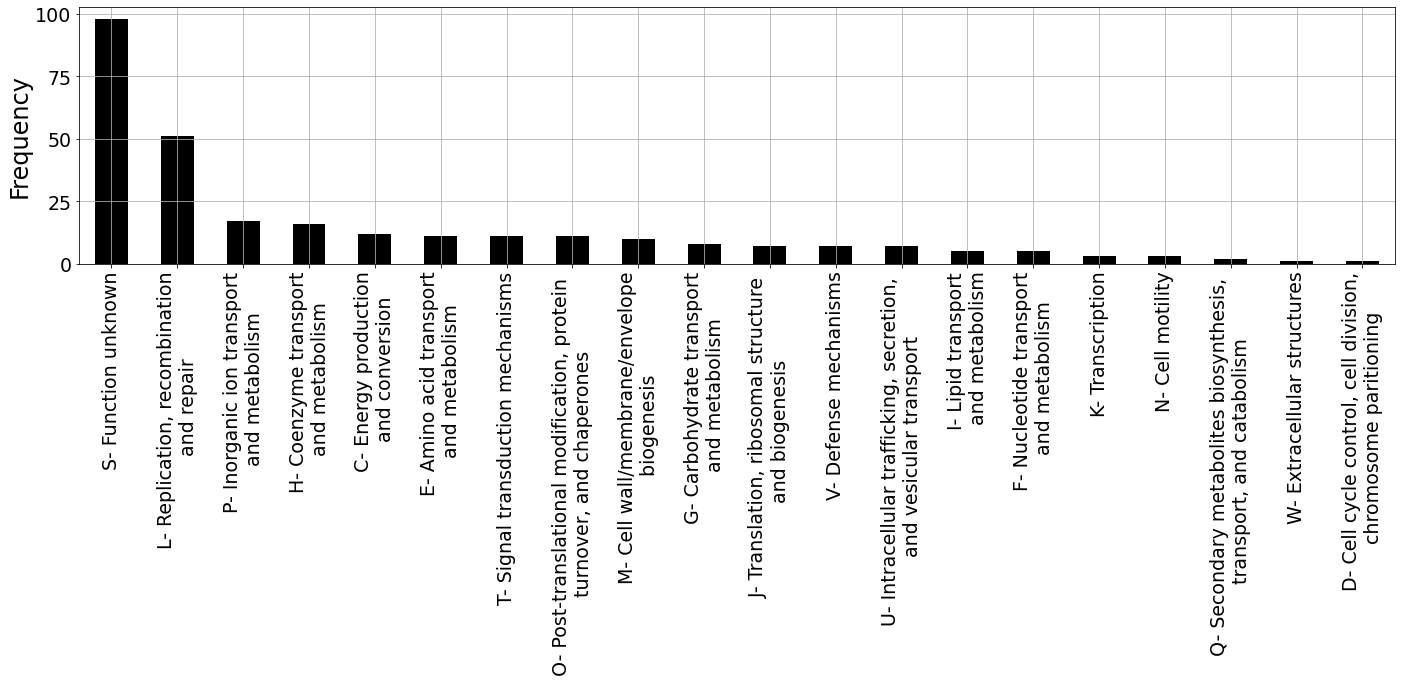

In [17]:
filtered_grp = pd.read_excel('/Users/harihara/Mount-2/hotspring_metagenome/Synechococcus_paper_analysis/\
Hotsprings_Variant_Structure_Data_Analysis/Synechococcus/Filtered.Eggnog.Annotations.xlsx')
#filtered_grp = filtered_grp.loc[(filtered_grp['OSA_Unaligned'] >= 400) & (filtered_grp['OSB_Unaligned'] >= 400)]
print(len(filtered_grp['GroupID'].unique()))
plt.rcParams.update(rcParams)

COG_categories = filtered_grp['COG_category'].tolist()
counts = {}
for c in COG_categories:
    try:
        for i in c:
            if i == '-':
                i = 'S'
            try:
                counts[i] += 1
            except KeyError:
                counts[i] = 1
    except TypeError:
        print(c,'Error')
        
df_COG_Counts = pd.DataFrame(data = {'COG':list(counts.keys()), 'Counts':list(counts.values())})
df_COG_Counts = df_COG_Counts.set_index('COG').sort_values(by = 'Counts', ascending = False)
df_COG_Counts = df_COG_Counts.join(df_COG_Desc).set_index('Description')

fig, ax = plt.subplots(1,1,figsize = (20,10))
df_COG_Counts[['Counts']].plot(kind = 'bar',ax = ax, legend = False, color = 'black',fontsize = 19)
ax.set_ylabel('Frequency')
ax.set_xlabel('')
ax.grid()
#ax.set_xscale('log', base = 5)
fig.tight_layout()
fig.savefig(out_dir+'EggNOG-Hits.pdf')

In [12]:
plt.rcParams.update(rcParams)

for g in list(filtered_grp['GroupID'].unique()):    
    print(g)
    contigs = d[g]+[d_representatives[g][0]]
    osa_contig_count, osb_contig_count = 0, 0
    osa_contigs, osb_contigs = [], []
    df_osa, df_osb = pd.DataFrame(), pd.DataFrame()
    
    for c in contigs:
        splits = c.split('_')
        contig = splits[-2]+'_'+splits[-1]
        genome = splits[-3].upper()
        sample = "_".join(splits[:-3])
        
        if genome == "OSA": osa_contig_count += 1
        if genome == "OSB": osb_contig_count += 1
        
        try:
            row = novel_contigs[sample][genome].loc[contig]
            row['Group'] = g
            row['Sample'] = sample
            if genome == 'OSA': df_osa = df_osa.append(row)
            elif genome == 'OSB': df_osb = df_osb.append(row)
        except:
            print("Missing...",sample,genome,contig)
            pass
    
    if len(df_osa) > 0: df_osa = df_osa.reset_index()
    if len(df_osb) > 0: df_osb = df_osb.reset_index()
    
    osa_counts, osb_counts, osa_gbl_counts, osb_gbl_counts = Make_Counts(df_osa, df_osb, osa_len, osb_len)
    osa_gbl_counts += 25
    osb_gbl_counts += 25
    
    ylim = max(np.max(osa_gbl_counts), np.max(osb_gbl_counts))    
    starts = df_prodigal_hits.loc[df_prodigal_hits['GroupID'] == g, 'Start'].tolist()
    ends = df_prodigal_hits.loc[df_prodigal_hits['GroupID'] == g, 'End'].tolist()
    orientations = df_prodigal_hits.loc[df_prodigal_hits['GroupID'] == g, 'Orientation'].tolist()
    cog_categories = df_prodigal_hits.loc[df_prodigal_hits['GroupID'] == g, 'COG_category'].tolist()
    desc = df_prodigal_hits.loc[df_prodigal_hits['GroupID'] == g, 'Description'].tolist()
    preferred_name = df_prodigal_hits.loc[df_prodigal_hits['GroupID'] == g, 'Preferred_name'].tolist()
    
    fig = plt.figure(figsize=(20, 15))
    gs = GridSpec(nrows=2, ncols=2, height_ratios=[2.75, 1.25])
    ax0 = fig.add_subplot(gs[0, 0], projection = 'polar')
    ax1 = fig.add_subplot(gs[0, 1], projection = 'polar')
    ax2 = fig.add_subplot(gs[1, :])
    
    osa_alignments_starts = df_blast.loc[(df_blast['GroupID'] == g) & (df_blast['sseqid'] == 'OSA') ,
                                         'qstart'].tolist()
    osa_alignments_ends = df_blast.loc[(df_blast['GroupID'] == g) & (df_blast['sseqid'] == 'OSA') ,
                                         'qend'].tolist()
    
    osb_alignments_starts = df_blast.loc[(df_blast['GroupID'] == g) & (df_blast['sseqid'] == 'OSB') ,
                                         'qstart'].tolist()
    osb_alignments_ends = df_blast.loc[(df_blast['GroupID'] == g) & (df_blast['sseqid'] == 'OSB') ,
                                         'qend'].tolist()
    try:
        width = df_prodigal_hits.loc[df_prodigal_hits['GroupID'] == g, 'Qlen'].tolist()[0]
    except IndexError:
        print(g, 'missing!!!!')
        continue
    ax2.plot([0, width],[4,4], linewidth=20, color = 'black')
        
    for i in range(len(osa_alignments_starts)):
        start = min(osa_alignments_starts[i], osa_alignments_ends[i])
        end = max(osa_alignments_starts[i], osa_alignments_ends[i])
        ax2.plot([start, end], [3, 3], color = 'green', linewidth = 10)
        
    for i in range(len(osb_alignments_starts)):
        start = min(osb_alignments_starts[i], osb_alignments_ends[i])
        end = max(osb_alignments_starts[i], osb_alignments_ends[i])
        ax2.plot([start, end], [2, 2], color = 'orange', linewidth = 10)
    
    for i in range(0, len(starts)):
        if len(desc[i]) > 50:
            print(desc[i])
            desc[i] = 'COG-Category: '
        
        if orientations[i] == '+':
            ax2.arrow(int(starts[i]),1,int(ends[i])-int(starts[i])+1,0, width = 0.25, alpha = 0.8, 
                      length_includes_head = True, head_length = 20, color = colors[cog_categories[i]], 
                      label = desc[i]+' ('+cog_categories[i]+','+str(preferred_name[i])+')')
        else:
            ax2.arrow(int(ends[i]),1,int(starts[i])-int(ends[i])+1,0, width = 0.25, alpha = 0.8, 
                      length_includes_head = True, head_length = 20, color = colors[cog_categories[i]], 
                      label = desc[i]+' ('+cog_categories[i]+','+str(preferred_name[i])+')')
    ax2.set_ylim([-1, 5])
    ax2.set_yticks([])
    fig.tight_layout()
    handles, labels = ax2.get_legend_handles_labels()
    fig.legend(handles, labels, loc=3, ncol = 3, fontsize = 16, frameon = False)
    
    label=("Synechococcus Sub.Sp A\n"+"#Contigs (in Group):"+str(osa_contig_count))
    Make_Circle_Plots(ax0, osa_gbl_counts, 'green', label, ylim)
    label=("Synechococcus Sub.Sp B\n"+"#Contigs (in Group):"+str(osb_contig_count))
    Make_Circle_Plots(ax1, osb_gbl_counts, 'orange', label, ylim)
    fig.suptitle(g.replace("_"," "))
    fig.tight_layout()
    fig.subplots_adjust(bottom=0.1)
    fig.savefig(out_dir+'Novel_Groups/'+g+'.pdf')
    plt.close("all")


Group_3180
Group_2966
COG1429 Cobalamin biosynthesis protein CobN and related Mg-chelatases
Group_1635
Group_2086
Group_2881
Group_2353
Catalyzes the formation of 4-diphosphocytidyl-2-C- methyl-D-erythritol from CTP and 2-C-methyl-D-erythritol 4- phosphate (MEP)
Group_1580
Group_2565
PFAM ATPase family associated with various cellular activities (AAA)
Group_2523
Group_1160
Belongs to the class-I aminoacyl-tRNA synthetase family
Group_2276
Belongs to the mandelate racemase muconate lactonizing enzyme family
Catalyzes the reaction of cyanate with bicarbonate to produce ammonia and carbon dioxide
Group_2702
Group_2750
TIGRFAM CRISPR-associated protein Cas6, subtype MYXAN
Group_2619
Group_665
COG0719 ABC-type transport system involved in Fe-S cluster assembly, permease component
Group_1708
Group_3442
Group_3450
Group_2888
Dihydrolipoamide acetyltransferase component of pyruvate dehydrogenase complex
Group_3496
Group_3391
Specifically catalyzes the decarboxylation of meso- diaminopimelate (

Group_2806
Group_2905
Group_3628
Group_3634
Group_2708
Group_1206
Group_2725
COG1502 Phosphatidylserine phosphatidylglycerophosphate cardiolipi n synthases and related enzymes
Group_2797
COGs COG3328 Transposase and inactivated derivatives
Group_1390
Cell wall formation. Catalyzes the addition of glutamate to the nucleotide precursor UDP-N-acetylmuramoyl-L-alanine (UMA)
Group_2401
Group_2548
Group_3678
Group_3678 missing!!!!
Group_2081
Group_3291
Group_3404
Group_3618
Group_3713
Group_3617
Group_3624
PFAM Branched-chain amino acid transport system permease component
Group_3516
Group_3513
Group_1903
Group_3745
Group_3725
Group_2095
Group_3357
Group_3734
Group_3008


In [19]:
pdfs = list(filtered_grp['GroupID'].unique())
pdfs.sort()
merger = PdfMerger()
for pdf in pdfs:
    if pdf.startswith('Group'):
        try:
            print(pdf)
            merger.append(out_dir+'Novel_Groups/'+pdf+'.pdf')
        except FileNotFoundError:
            print(pdf, 'not found')
        
merger.write(out_dir+'Circos_Intersting_Groups.pdf')
merger.close()

Group_1160
Group_1206
Group_1287
Group_1390
Group_1565
Group_1580
Group_1635
Group_1673
Group_1708
Group_1775
Group_1829
Group_1855
Group_1862
Group_1903
Group_1949
Group_2033
Group_2061
Group_2079
Group_2080
Group_2081
Group_2086
Group_2095
Group_2200
Group_2235
Group_2270
Group_2276
Group_2294
Group_2299
Group_2343
Group_2353
Group_2388
Group_2398
Group_2401
Group_2442
Group_2523
Group_2548
Group_2551
Group_2565
Group_2596
Group_2619
Group_2620
Group_2635
Group_2700
Group_2702
Group_2708
Group_2724
Group_2725
Group_2733
Group_2745
Group_2750
Group_2782
Group_2795
Group_2796
Group_2797
Group_2799
Group_2806
Group_2820
Group_2821
Group_2822
Group_2829
Group_2845
Group_2876
Group_2881
Group_2888
Group_2905
Group_2914
Group_2925
Group_2926
Group_2966
Group_2998
Group_3008
Group_3028
Group_3035
Group_3036
Group_3038
Group_3087
Group_3114
Group_3132
Group_3157
Group_3180
Group_3197
Group_3206
Group_3213
Group_3231
Group_3244
Group_3244 not found
Group_3263
Group_3266
Group_3267
Group_3272
